# Time frequency mapping after time-domain whitening on the GW signals
Time-frequency mapping after time-domain whitening on gravitational wave (GW) signals can be a crucial step in signal processing within the domain of GW astronomy. Time-domain whitening is a preprocessing technique used to flatten the spectral density of GW signals, making them better suited for subsequent analysis. Once the signals have been whitened, time-frequency mapping techniques are employed to provide a more comprehensive understanding of their spectral characteristics over time. These mapping methods allow researchers to visualize how the frequency content of GW signals evolves throughout the duration of an observation.  

## Implement the whitening using AR model

### Create AR model

In [1]:
# Import necessary modules
import time
import os
import json 
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import Parameters
from wdf.processes.Whitening import Whitening
from wdf.processes.DWhitening import  DWhitening
from wdf.processes.DownSampling import *
from pytsa.tsa import FrameIChannel
import logging, sys

# Configure logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Set up logging output to console
console_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(console_handler)

# Log a debug message
logging.debug("info")
 
# Get the current working directory
path = os.getcwd()
 
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(path, os.pardir))
filein = os.path.join(parent_dir, "caches/E1.ffl")
 
# Flag to determine whether to create a new JSON configuration file
new_json_config_file = True

# Create or update JSON configuration file if needed
if new_json_config_file:
    configuration = {
        "file": filein,
        "channel": 'E1:STRAIN', 
        "len": 2.0,
        "gps": 1000000001.,
        "outdir": "./",
        "dir": "./", 
        "ARorder": 1000,
        "learn": 200,
        "preWhite": 4,
        "ResamplingFactor": 4,
    }

filejson = os.path.join(os.getcwd(), "WavRecDS.json")
file_json = open(filejson, "w+")
json.dump(configuration, file_json)
file_json.close()

# Load parameters from the JSON configuration file
par = Parameters()
filejson = "WavRecDS.json"
try:
    par.load(filejson)
    logging.info("Read parameters from JSON file")
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()

# Initialize FrameIChannel
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
par.resampling = par.sampling / par.ResamplingFactor

# Log information about the channel and sampling frequency
logging.info("Channel = %s at sampling frequency = %s" %(par.channel, par.resampling))

# Initialize Whitening object
whiten = Whitening(par.ARorder)

# Set paths for AR and LV coefficient files
par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
    par.ARorder, par.resampling, par.channel)
par.LVfile = "./LVcoeff-AR%s-fs%s-%s.txt" % (
    par.ARorder, par.resampling, par.channel)

# Load AR parameters if files exist, otherwise estimate and save AR parameters
if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
    logging.info('Load AR parameters')
    whiten.ParametersLoad(par.ARfile, par.LVfile)
else:
    logging.info('Start AR parameter estimation')
    # Read data for AR estimation
    strLearn = FrameIChannel(
        par.file, par.channel, par.learn, par.gps
    )
    Learn = SV()
    Learn_DS = SV()
    par.Noutdata = int(par.learn * par.resampling)
    ds = DownSampling(par, estimation=True)
    strLearn.GetData(Learn)
    Learn_DS = ds.Process(Learn)
    whiten.ParametersEstimate(Learn_DS)
    whiten.ParametersSave(par.ARfile, par.LVfile)
    del Learn, ds, strLearn, Learn_DS


Read parameters from JSON file
Channel = E1:STRAIN at sampling frequency = 2048.0
Load AR parameters


In [2]:
# sigma for the noise
par.sigma = whiten.GetSigma()
logging.info('Estimated sigma= %s' % par.sigma)

Estimated sigma= 1.24174e-23


In [3]:
# Determine the number of data points based on the resampling rate and signal duration
N = int(par.resampling * par.len)

# Define padding length for downsampling
padlen = int(par.sampling / 4)

# Update the number of output data points
par.Noutdata = N

# Initialize downsampling object
ds = DownSampling(par, padlen=padlen)

# Initialize DWhitening object with LV coefficients and data length
Dwhiten = DWhitening(whiten.LV, N, 0)

# Initialize FrameIChannel for streaming data
streaming = FrameIChannel(par.file, par.channel, par.len, par.gps)

# Initialize SV objects to hold data
data = SV()
dataw = SV()
dataww = SV()

# Load LV parameters if the file exists
if os.path.isfile(par.LVfile):
    logging.info('Load LV parameters')
    Dwhiten.ParametersLoad(par.LVfile)

# Whitening preheating loop
for i in range(par.preWhite):
    # Get data from the streaming channel
    streaming.GetData(data)
    
    # Downsample the data
    data_ds = ds.Process(data)
    
    # Apply whitening
    whiten.Process(data_ds, dataw)
    
    # Apply whitening with DWhitening
    Dwhiten.Process(data_ds, dataww)

 
    

Estimation status is set to False. If you need to estimate AR, please update the value
Load LV parameters


In [4]:
# Obtain data from the streaming channel
streaming.GetData(data)

# Process the data through downsampling
data_ds = ds.Process(data)

# Apply whitening to the downsampled data
whiten.Process(data_ds, dataw)

# Apply whitening with DWhitening to the downsampled data
Dwhiten.Process(data_ds, dataww)


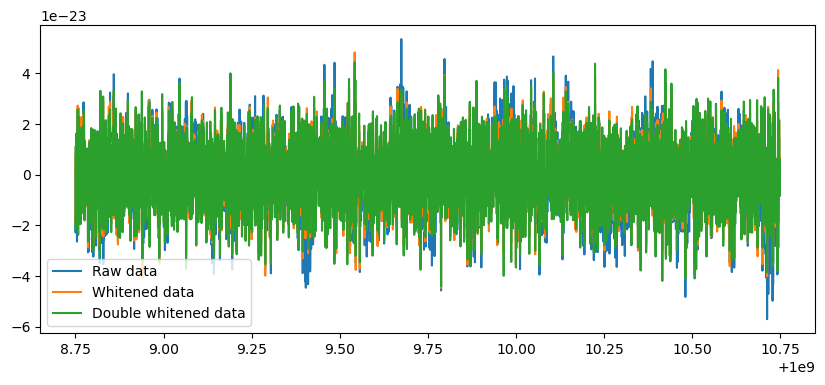

In [5]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
import IPython
import IPython.display
import matplotlib as mpl
from matplotlib import cm
from scipy import signal
from matplotlib.colors import LogNorm
from PIL import Image

# Import NumPy library
import numpy as np

# Set matplotlib configuration parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Initialize arrays to store data
x = np.zeros(dataw.GetSize())
y = np.zeros(dataw.GetSize())
yw = np.zeros(dataw.GetSize())
yww = np.zeros(dataww.GetSize())

# Populate arrays with data from SV objects
for i in range(dataw.GetSize()):
    x[i] = data_ds.GetX(i)
    y[i] = data_ds.GetY(0, i)
    yw[i] = dataw.GetY(0, i)
    yww[i] = dataww.GetY(0, i)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='Raw data')
plt.plot(x, yw, label='Whitened data')
plt.plot(x, yww, label='Double whitened data')

# Add legend
plt.legend()

# Show plot
plt.show()
plt.close()


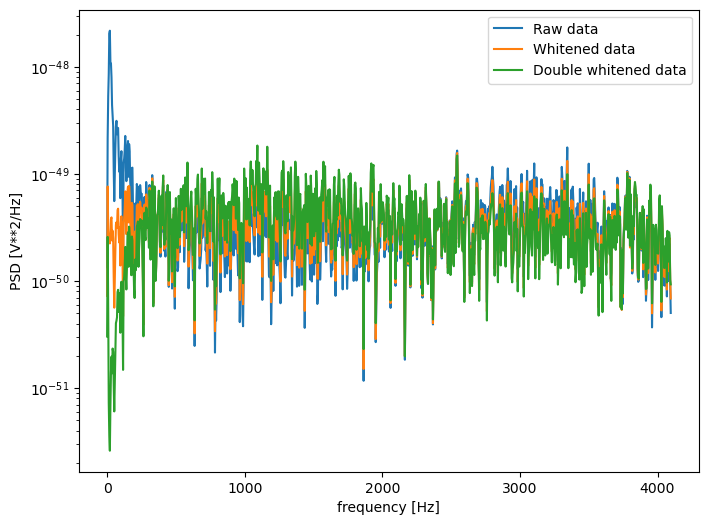

In [6]:
 

# Calculate power spectral density (PSD) using Welch's method
f, Pxx_den = signal.welch(y, par.sampling, nperseg=2048)
f, Pxx_denW = signal.welch(yw, par.sampling, nperseg=2048)
f, Pxx_denWW = signal.welch(yww, par.sampling, nperseg=2048)

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot PSD for raw data
ax.semilogy(f, Pxx_den, label='Raw data')

# Plot PSD for whitened data
ax.semilogy(f, Pxx_denW, label='Whitened data')

# Plot PSD for double whitened data
ax.semilogy(f, Pxx_denWW, label='Double whitened data')

# Set labels for x and y axes
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

# Add legend
plt.legend()

# Show plot
plt.show()
plt.close()


## Spectrogram

In [7]:


def prepareImage(y, fs, title):
    """
    Create and display a spectrogram plot using the Short-Time Fourier Transform (STFT).

    Parameters:
        y (numpy.ndarray): Signal data.
        fs (float): Sampling frequency.
        title (str): Title for the plot.

    Returns:
        None
    """
    # Calculate the spectrogram using the Short-Time Fourier Transform (STFT)
    f, t, Sxx = signal.spectrogram(y, fs)
    
    # Create a pseudocolor mesh plot using the spectrogram data
    plt.pcolormesh(t, f, Sxx, cmap='viridis', shading='gouraud', alpha=0.95)
    
    # Set the y-axis scale to logarithmic
    plt.yscale('log')
    
    # Set the y-axis limits to be between 10 Hz and half of the sampling frequency
    plt.ylim(10, fs/2)
    
    # Set the title for the plot
    plt.title(str(title))
    
    # Set labels for the x and y axes
    plt.xlabel('Time (secs)')
    plt.ylabel('Frequency (Hz)')
    
    # Add a colorbar to the plot for visualization
    plt.colorbar()
    
    # Display the spectrogram plot
    plt.show()
    plt.close()

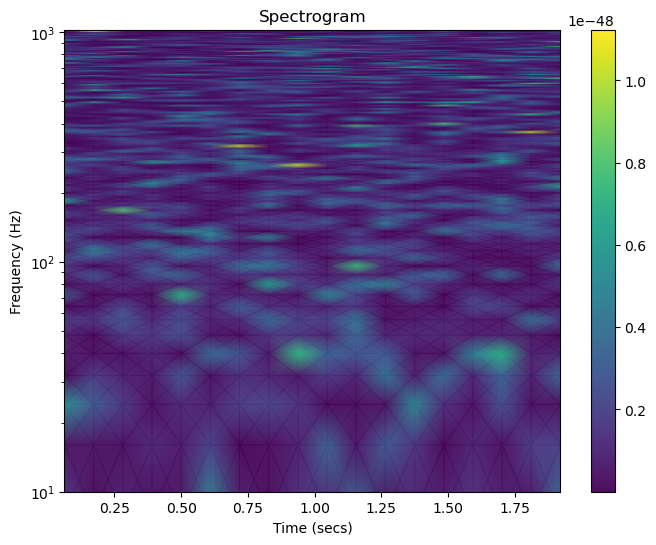

In [8]:
fs=par.resampling
prepareImage(yw,fs,title="Spectrogram")

## Wavelet map

In [9]:
#if needed
!pip install ssqueezepy --user

In [10]:
from ssqueezepy import cwt  # Import the continuous wavelet transform function from the ssqueezepy package
from ssqueezepy import imshow  # Import the imshow function from the ssqueezepy package

def prepareImage_cwt(y, fs):
    """
    Compute and visualize the continuous wavelet transform (CWT) of a given signal.

    Parameters:
    - y: The input signal to be analyzed.
    - fs: The sampling frequency of the signal.

    Returns:
    None
    """
    # Compute the continuous wavelet transform (CWT) using the Morlet wavelet
    Wx, scales = cwt(y, 'morlet')
    
    # Visualize the CWT coefficients using imshow
    imshow(Wx, yticks=scales, abs=1)
    
 

    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


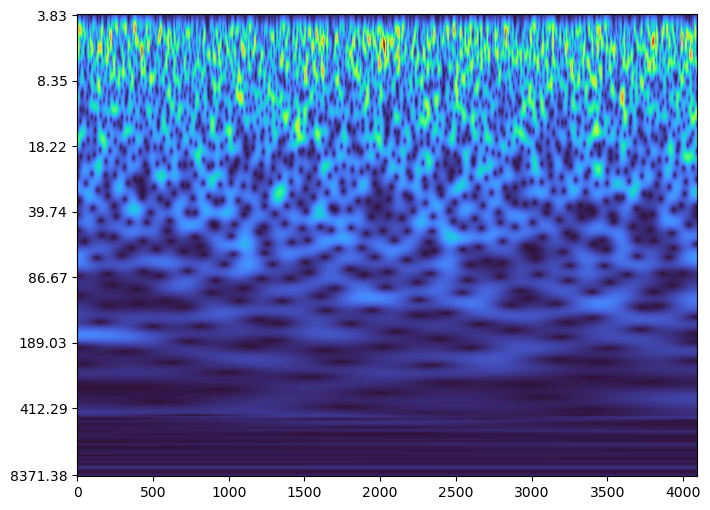

In [11]:
# Call the function to prepare and visualize the CWT of the input signal
prepareImage_cwt(yw, fs) 

## Let's whiten the data containing a high-SNR signal and plot it for not whitened and whitened data

In [ ]:
# Define the GPS time of the event
tc = 1001620463.11925

# Set the file path
par.file = '../caches/E1.ffl'

# Set the duration of the signal
par.len = 4.0
lenS = par.len

# Calculate the number of data points based on the resampling rate and signal duration
N = int(par.resampling * lenS)

# Define padding length for downsampling
padlen = int(par.sampling / 4)

# Update parameters
par.Noutdata = N
par.len = lenS

# Calculate the GPS time for the start of the data segment
gpsEvent = tc
gps = gpsEvent - par.len - (par.preWhite) * lenS + padlen / par.sampling

# Initialize downsampling object
ds = DownSampling(par, padlen=padlen)

# Initialize DWhitening object with LV coefficients and data length
Dwhiten = DWhitening(whiten.LV, N, 0)

# Initialize FrameIChannel for streaming data with adjusted GPS time
streaming = FrameIChannel(par.file, par.channel, lenS, gps)

# Re-initialize SV objects to hold data
del data, dataw, dataww, data_ds
data = SV()
dataw = SV()
dataww = SV()

# Whitening preheating loop
for i in range(par.preWhite):
    # Get data from the streaming channel
    streaming.GetData(data)
    
    # Process the data through downsampling
    data_ds = ds.Process(data)
    
    # Apply whitening
    whiten.Process(data_ds, dataw)
    
    # Apply whitening with DWhitening
    Dwhiten.Process(data_ds, dataww)


Estimation status is set to False. If you need to estimate AR, please update the value


In [ ]:
# Get data from the streaming channel
streaming.GetData(data)

# Process the data through downsampling
data_ds = ds.Process(data)

# Apply whitening to the downsampled data
whiten.Process(data_ds, dataw)

# Apply whitening with DWhitening to the downsampled data
Dwhiten.Process(data_ds, dataww)

# Initialize arrays to store data for plotting
x = np.zeros(dataw.GetSize())
y = np.zeros(dataw.GetSize())
yw = np.zeros(dataw.GetSize())
yww = np.zeros(dataww.GetSize())

# Populate arrays with data from SV objects
for i in range(dataw.GetSize()):
    x[i] = data_ds.GetX(i)
    y[i] = data_ds.GetY(0, i)
    yw[i] = dataw.GetY(0, i)
    yww[i] = dataww.GetY(0, i)


In [ ]:
fig, ax = plt.subplots()

ax.plot(x, y,  label='Raw data')
ax.plot(x, yw, label='whitened data')
ax.plot(x, yww, label='D-whitened data')
ax.legend()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
plt.figure()

plt.plot(x, yw, 'c',label='whitened data')
plt.show()
plt.close()

In [ ]:
 
# Initialize arrays to store raw data
xraw = np.zeros(data.GetSize())
yraw = np.zeros(data.GetSize())

# Populate arrays with raw data
for i in range(data.GetSize()):
    xraw[i] = data.GetX(i)
    yraw[i] = data.GetY(0, i)

# Sampling frequencies
fs = par.sampling
frs = par.resampling

# Calculate power spectral density (PSD) using Welch's method for raw data
fraw, Pxx_denraw = signal.welch(yraw, par.sampling, nperseg=fs)

# Calculate PSD using Welch's method for downsampled raw data
f, Pxx_den = signal.welch(y, par.resampling, nperseg=frs)

# Calculate PSD using Welch's method for downsampled and whitened data
fds, Pxx_denDS = signal.welch(yw, par.resampling, nperseg=frs)

# Calculate PSD using Welch's method for downsampled and double whitened data
fw, Pxx_denW = signal.welch(yww, par.resampling, nperseg=frs)

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PSD for raw data
ax.loglog(fraw, np.sqrt(Pxx_denraw), 'b', label='Raw data', linewidth=2)

# Plot PSD for downsampled raw data
ax.loglog(f, np.sqrt(Pxx_den), 'gray', label='Downsampled Raw Data')

# Plot PSD for downsampled and whitened data
ax.loglog(fds, np.sqrt(Pxx_denDS), 'g', label='Resampled + Whitened') 

# Plot PSD for downsampled and double whitened data
ax.loglog(fw, np.sqrt(Pxx_denW), 'r', label='Resampled + Double Whitened')

# Set labels for x and y axes
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

# Add legend and set y-axis limit
plt.legend(), plt.ylim(1e-26, 1e-18), plt.grid(which='both')
plt.show()
# Close the plot
plt.close()


In [ ]:
prepareImage_cwt(y,par.resampling)

In [ ]:
prepareImage_cwt(yw,par.resampling)

prepareImage_gw(x,yww,par.resampling)

## <font color='purple'> Challenge: Could you prepare the same plot for a signal with SNR <30? </font>